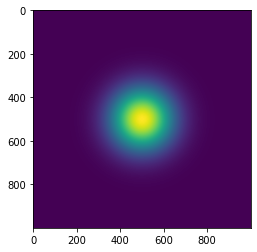

In [39]:
import cv2
import  numpy  as  np
import matplotlib.pyplot as plt

# Usage : Instantiate a class GaussianGenerator
#         Use gen(shape, boxes)
# Input : Output_shape and list of boxes
# Return : gaussian heat map (max value 1)

# Returns a 2D Isotropic Gaussian Map
# Input : None
def gaussian_2d():

    var = 1/(2*np.pi)
    a = np.sqrt(1 / (2 * np.pi * var))
    x, y = np.meshgrid(np.arange(-5, 5, 0.01), np.arange(-5, 5, 0.01))
    data = np.vstack([x.flatten(), y.flatten()]).T

    x1 = (data[:, 0]) ** 2
    y1 = (data[:, 1]) ** 2
    gaussian_map = a * np.exp(-0.5 * (x1 + y1)/var)
    gaussian_map = gaussian_map.reshape(len(x), len(y))

    max_prob = np.max(gaussian_map)
    min_prob = np.min(gaussian_map)
    gaussian_map = (gaussian_map - min_prob) / (max_prob - min_prob)
    gaussian_map = np.clip(gaussian_map, 0., 1.)
    # plt.imshow(g)
    # g = gaussian_map
    # print(g.shape)
    # print(x.shape)
    # plt.pcolormesh(x, y, g)
    return gaussian_map
    
# Class for generating Gaussian Maps transformed to a box
class  GaussianGenerator :
    def __init__(self):
        self.gaussian_img = gaussian_2d()

    @staticmethod
    def perspective_transform(src, dst_shape, dst_points):
        """
        src - Image to be transformed (Gaussian map)
        dst_shape - The shape of the image required after transformation
        dst_points - The corners of the image required after transformation
        """
        img = src.copy()
        h, w = img.shape[:2]
        # Follows x, y system
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])    
        dst_points = np.float32(dst_points)
        # Computes perspective tranformation
        perspective_mat = cv2.getPerspectiveTransform(src_points, dst_points) 
        # Warps the src (Gaussian)
        dst = cv2.warpPerspective(img, perspective_mat, (dst_shape[1], dst_shape[0]), 
                                  borderValue=0, borderMode=cv2.BORDER_CONSTANT)
        return dst

    # Returns gaussian Map transformed to char boxes (Returns the score region/affinity)
    # Input : Final Image shape and a list of boxes to be warped
    def gen(self, score_shape, boxes):
        score_map = np.zeros(score_shape, dtype=np.float32)
        for box in boxes:
            tmp_score_map = self.perspective_transform(self.gaussian_img, score_shape, box)
            # Max among multiple possibilities
            score_map = np.where(tmp_score_map > score_map, tmp_score_map, score_map)  
        score_map = np.clip(score_map, 0, 1.)
        return score_map